## Import Dependancies

In [1]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

In [ ]:
!pip list

Package                          Version
-------------------------------- -----------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict

In [2]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('TPU')

[]

In [4]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete39CUL9/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete39CUL9/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [6]:
ds.as_numpy_iterator().next()['label']

2

## Data Viz and remake dataset

In [7]:
import numpy as np

In [8]:
data_iterator = ds.as_numpy_iterator()

In [ ]:
#bring new datasets each and every time consistantly out of the pipeline
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

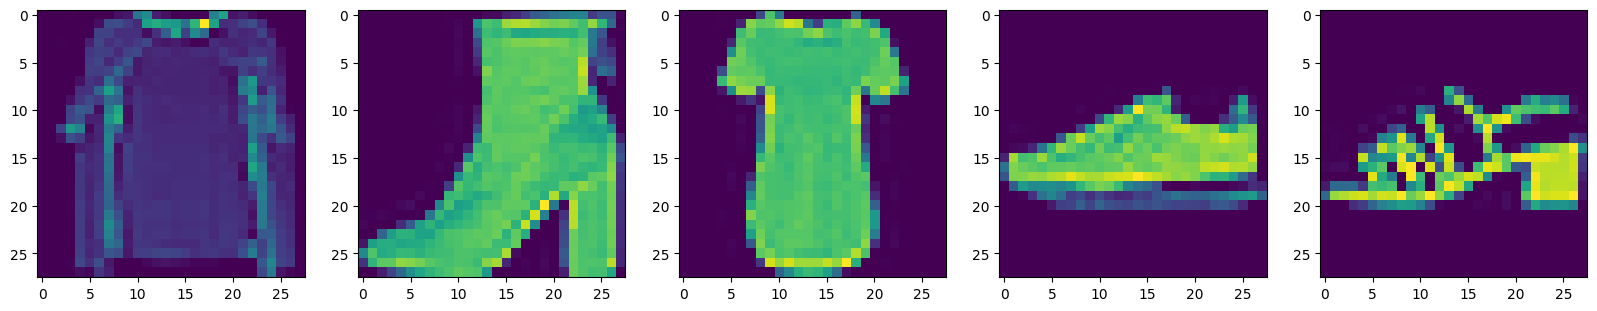

In [13]:
#setup subplots
fig, axis = plt.subplots(ncols=5, figsize = (20,20))

for index in range(5):
  sample = data_iterator.next()
  #plot images from data_iterator
  axis[index].imshow(np.squeeze(sample['image'])) #squeeze for collapse the array

In [14]:
# Scale and return images only - normalizing for better results
def scale_images(data):
    image = data['image']
    return image / 255

In [15]:
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# eliminates bottlenecking
ds = ds.prefetch(64)

In [16]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## Build Neural Networks - discriminator & generator

In [17]:
import tensorflow as tf
model_generator = tf.keras.models.Sequential([
  #Beginning of a generated image - reshapes to 7*7*128. need to be 28*28*1
  tf.keras.layers.Dense(7*7*128, input_dim=128), #input layer with 7*7*128 neurons. 128 is a random batch size number
  tf.keras.layers.LeakyReLU(0.2), #cater non-linearities
  tf.keras.layers.Reshape((7,7,128)),

  #upsampling block 1
  tf.keras.layers.UpSampling2D(), #double the output value to 14*14*128
  tf.keras.layers.Conv2D(128, 5, padding='same'),
  tf.keras.layers.LeakyReLU(0.2),

  #upsampling block 2
  tf.keras.layers.UpSampling2D(), #double the output value to 28*28*128
  tf.keras.layers.Conv2D(128, 5, padding='same'),
  tf.keras.layers.LeakyReLU(0.2),

  # Convolutional block 1
  #ability to pass more parameters in neural network to learn much better
  tf.keras.layers.Conv2D(128, 4, padding='same'),
  tf.keras.layers.LeakyReLU(0.2),

  # Convolutional block 2
  #ability to pass more parameters in neural network to learn much better
  tf.keras.layers.Conv2D(128, 4, padding='same'),
  tf.keras.layers.LeakyReLU(0.2),

  #final convolutiuon layer to get to one channel - same size as input data
  tf.keras.layers.Conv2D(1, 4, padding='same', activation='sigmoid') #sigmoid for binary classification

])

In [18]:
model_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [19]:
#generate some random images
img = model_generator.predict(np.random.randn(5,128,1)) #generate 4 images with 128 values
img.shape #check the size of a generated images. should be 28*28*1

1/1 [==============================] - 1s 759ms/step


(5, 28, 28, 1)

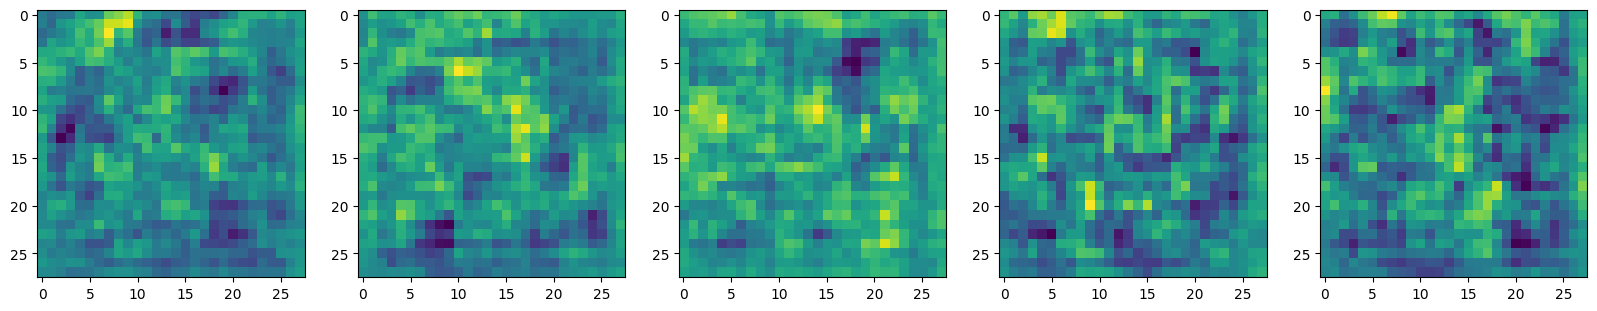

In [20]:
#visualize the generated images using matplotlib
#setup subplots
fig, axis = plt.subplots(ncols=5, figsize = (20,20))

for index,img in enumerate(img):
  #sample = data_iterator.next()
  #plot images from data_iterator
  axis[index].imshow(np.squeeze(img)) #squeeze for collapse the array

In [21]:
model_discriminator = tf.keras.models.Sequential([

  #1st convo layer block
  tf.keras.layers.Conv2D(32, 5, input_shape = (28,28,1)), #32 filters which is 5*5 size
  tf.keras.layers.LeakyReLU(0.2), #cater non-linearities
  tf.keras.layers.Dropout(0.4), #apply some regularization

  #2nd convo layer block
  tf.keras.layers.Conv2D(64, 5), #32 filters which is 5*5 size
  tf.keras.layers.LeakyReLU(0.2), #cater non-linearities
  tf.keras.layers.Dropout(0.4), #apply some regularization

  #3rd convo layer block
  tf.keras.layers.Conv2D(128, 5), #32 filters which is 5*5 size
  tf.keras.layers.LeakyReLU(0.2), #cater non-linearities
  tf.keras.layers.Dropout(0.4), #apply some regularization

  #4th convo layer block
  tf.keras.layers.Conv2D(256, 5), #32 filters which is 5*5 size
  tf.keras.layers.LeakyReLU(0.2), #cater non-linearities
  tf.keras.layers.Dropout(0.4), #apply some regularization

  # Flatten then pass to dense layer
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
img = img[0]

In [ ]:
img.shape

(28, 1)

In [ ]:
model_discriminator.predict(np.expand_dims(img,0))

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'conv2d_5' (type Conv2D).
    
    Negative dimension size caused by subtracting 5 from 1 for '{{node sequential_1/conv2d_5/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_1/ExpandDims, sequential_1/conv2d_5/Conv2D/ReadVariableOp)' with input shapes: [?,28,1,1], [5,5,1,32].
    
    Call arguments received by layer 'conv2d_5' (type Conv2D):
      • inputs=tf.Tensor(shape=(None, 28, 1, 1), dtype=float32)


## Construct Training Loop

In [23]:
import tensorflow as tf
# set losses and optimizers to compile the model
#Adam as the optimizer for both generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.00001)
#BinaryCrossentropy as the loss function for both generator and discriminator
generator_loss = tf.keras.losses.BinaryCrossentropy()
discriminator_loss = tf.keras.losses.BinaryCrossentropy()

In [24]:
from tensorflow.keras.models import Model
tf.keras.models.Model()

In [25]:
class GAN(Model):
  def __init__(self, model_generator, model_discriminator, *args, **kwargs):
     super().__init__(*args, **kwargs)

     # Create attributes for gen and disc
     self.model_generator = model_generator
     self.model_discriminator = model_discriminator

  def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss, *args, **kwargs):
      # Compile with base class
      super().compile(*args, **kwargs)

      # Create attributes for losses and optimizers
      self.generator_optimizer = generator_optimizer
      self.discriminator_optimizer = discriminator_optimizer
      self.generator_loss = generator_loss
      self.discriminator_loss = discriminator_loss

  def train_step(self, batch):
      # Get the data
      real_images = batch
      fake_images = self.model_generator(tf.random.normal((128, 128, 1)), training=False)

      # Train the model_discriminator
      with tf.GradientTape() as d_tape:
          # Pass the real and fake images to the discriminator model
          yhat_real = self.model_discriminator(real_images, training=True)
          yhat_fake = self.model_discriminator(fake_images, training=True)
          yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

          # Create labels for real and fakes images - real(0), fake(1)
          y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

          # Add some noise to the TRUE outputs
          noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
          noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
          y_realfake += tf.concat([noise_real, noise_fake], axis=0)

          # Calculate loss
          total_d_loss = self.discriminator_loss(y_realfake, yhat_realfake)

      # Apply backpropagation - nn learn
      dgrad = d_tape.gradient(total_d_loss, self.model_discriminator.trainable_variables)
      self.discriminator_optimizer.apply_gradients(zip(dgrad, self.model_discriminator.trainable_variables))

      # Train the model_generator
      with tf.GradientTape() as g_tape:
          # Generate some new images
          gen_images = self.model_generator(tf.random.normal((128,128,1)), training=True)

          # Create the predicted labels
          predicted_labels = self.model_discriminator(gen_images, training=False)

          # Calculate loss - trick to training to fake out the discriminator
          total_g_loss = self.generator_loss(tf.zeros_like(predicted_labels), predicted_labels)

      # Apply backprop
      ggrad = g_tape.gradient(total_g_loss, self.model_generator.trainable_variables)
      self.generator_optimizer.apply_gradients(zip(ggrad, self.model_generator.trainable_variables))

      return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [26]:
# Create instance of subclassed model
FashionGAN = GAN(model_generator, model_discriminator)

In [27]:
# Compile the model
FashionGAN.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

In [28]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [29]:
class SaveGenImg(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.model_generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [30]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [31]:
history = FashionGAN.fit(ds, epochs=10)

Epoch 1/10
  2/469 [..............................] - ETA: 4:20:02 - d_loss: 0.6955 - g_loss: 0.7066

KeyboardInterrupt: 

In [ ]:
plt.suptitle('Loss')
plt.plot(history.history['d_loss'], label='d_loss')
plt.plot(history.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [ ]:
imgs = model_generator.predict(tf.random.normal((25,128,1)))

In [ ]:
fig, axis = plt.subplots(ncols=5, nrows=5, figsize=(10,10))
for r in range(5):
    for c in range(5):
        axis[r][c].imshow(imgs[(r+1)*(c+1)-1])